In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Cuda/cpu device

In [3]:
device = ''
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
print(f'Your device is "{device}"')

Your device is "cpu"


In [105]:
np.random.seed(30)


# Data:
## Define functions to 
  - load and preprocess


In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
#import os
#os.chdir(r'/content/gdrive/MyDrive')

In [40]:
#ls

### Form correct list of directories (train and validation)

здесь необходимо прописать правильные пути до обучающей и валидационной выборок

In [43]:
train_path, val_path = '/content/gdrive/MyDrive/Colab Notebooks/train/train/', '/content/gdrive/MyDrive/Colab Notebooks/val/val/'

In [1]:
#test_path = '/content/gdrive/MyDrive/Colab Notebooks/val/val/'

In [4]:
def get_clean_data_paths(path: str):
    clean = 'clean/'
    list_clean = []
    with os.scandir(path+clean) as entries:
        for entry in entries:
            if entry.is_dir():
                list_clean.append(entry.path)
    return sorted(list_clean)

In [46]:
tr_clean_paths_list = get_clean_data_paths(train_path)

In [47]:
print(f'clean list length =', len(tr_clean_paths_list))

clean list length = 799


In [49]:
val_clean_paths_list = get_clean_data_paths(val_path)

In [50]:
print(f'val list length =', len(val_clean_paths_list))

val list length = 150


### Load data

In [5]:
def get_data_from_clean_data_paths(clean_data_paths: list):
    """
    input: paths to clean data
    output: loaded clean and noisy data to lists of np.arrays    
    """
    list_of_clean_data = []
    list_of_noisy_data = []
    
    cnt = 0
    #print(len(clean_data_paths))
    for path in clean_data_paths:
        cnt += 1
        if cnt % 10 == 0:
            print(cnt, path)
        
        with os.scandir(path) as entries:
            for input in entries:
                if input.is_file():
                    clean_path = input.path
                    noisy_path = input.path.replace('clean', 'noisy', 1)

                    list_of_clean_data.append(np.load(clean_path).T)
                    list_of_noisy_data.append(np.load(noisy_path).T)
    return list_of_clean_data, list_of_noisy_data
      

In [52]:
train_clean_data, train_noisy_data = get_data_from_clean_data_paths(tr_clean_paths_list[:])

10 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1094
20 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1403
30 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1505
40 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1595
50 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1664
60 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1715
70 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1760
80 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1863
90 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/1977
100 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/2042
110 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/2096
120 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/2246
130 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/2309
140 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/243
150 /content/gdrive/MyDrive/Colab Notebooks/train/train/clean/2544
160 /

In [54]:
val_clean_data, val_noisy_data = get_data_from_clean_data_paths(val_clean_paths_list[:])

10 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/1680
20 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/2237
30 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/2925
40 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/3779
50 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/428
60 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/4931
70 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/5545
80 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/5970
90 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/6184
100 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/6590
110 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/6963
120 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/7331
130 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/7702
140 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/8259
150 /content/gdrive/MyDrive/Colab Notebooks/val/val/clean/985


# Preparing training

### Training parameters

In [6]:
# batch size for training process
# batch size for evaluation process
train_batch_size = 64

dev_batch_size = 64

# part of train data for progress estimation
dev_part = 0.1

# starting learning rate
learning_rate = 0.001

layers = 15


# max number of epochs
max_epochs = 100

### We will construct batch here:


In [7]:
class Detect(Dataset):
    """
      data - clean and noisy data
      targets - noise residuals of the same size as noisy or clean data
    """
    def __init__(self, clean, noisy):
        #initialize class object
        
        #concatenate clean and noisy data lists
        self.data = noisy
        #generate corresponding targets
        self.targets = [noisy[i]-clean[i] for i in range(len(clean))]
        
    def __len__(self):
        #standard interface function for Dataset
        if self.data != None:
            return len(self.data)
        
    def __getitem__(self, idx):
        #standard interface function for Dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.data[idx], self.targets[idx]] #{'mel_data': self.data[idx], 'target': self.targets[idx]}
        return sample

In [8]:
def crop_function(arr1, arr2, step):
  
    start_cut_range = arr1.shape[1] - step
    start_rand = np.random.randint(0, start_cut_range+1)

    return (arr1[:, start_rand: start_rand+step], arr2[:, start_rand: start_rand+step])


def match_function(batch):

    min_len = 100000

    #extract data from input batch
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    for elem in data:
        min_len = min(min_len, elem.shape[1])
    
    temp_pairs = [crop_function(elem[0], elem[1], min_len) for elem in zip(data, targets)]
    data = [elem[0] for elem in temp_pairs]
    targets = [elem[1] for elem in temp_pairs]
    return [torch.tensor(data).float(), torch.tensor(targets).float()]
  
def get_new_shuffle(list1, list2):
    """
    Shuffles 2 lists of the same length in coherent manner
    and returns them.
    """
    if len(list1) != len(list2):
        print('wrong len!')
        return -1
    new_order = list(range(len(list1)))
    random.shuffle(new_order)
    new_list1 = [list1[new_order[i]] for i in new_order]
    new_list2 = [list2[new_order[i]] for i in new_order]
   
    return new_list1, new_list2


In [9]:
def get_DataLoader(clean_data_list, noisy_data_list, batch_size, shuffle=True):
   
    dataset = Detect(clean_data_list, noisy_data_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                            collate_fn=match_function, pin_memory=True)
    return dataloader

In [60]:
train_clean_data, train_noisy_data = get_new_shuffle(train_clean_data, train_noisy_data)

In [61]:
dev_data_length = int(len(train_clean_data)*dev_part)
train_data_length = len(train_clean_data) - dev_data_length

train_dataloader = get_DataLoader(train_clean_data[:train_data_length], 
                                  train_noisy_data[:train_data_length],
                                  train_batch_size)
dev_dataloader = get_DataLoader(train_clean_data[train_data_length:], 
                                train_noisy_data[train_data_length:],
                                dev_batch_size)

### Model definition
Here we will use 15-layer DnCNN network with BatchNorm layers.

In [10]:
class Denoising_Model(nn.Module):
    """
    Model definition.
    Y is residual
    X is clean data
    Y'is noisy data =>
    Y = Y'- X,
    X = Y' - Y
    Layers:
        1 Conv1D layer+ReLU,
        18 Conv1D layers+BatchNorm+RelU,
        1 Conv1D layer
    """
    def __init__(self, nLayers=10):
        super(Denoising_Model, self).__init__()
        #DnCNN architecture
        self.repeated_layers = nLayers-2
        self.conv_list = nn.ModuleList()
        for nLayer in range(self.repeated_layers):
            self.conv_list.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
            self.conv_list.append(nn.BatchNorm1d(64))
            self.conv_list.append(nn.ReLU())
            if nLayer > 0 and nLayer % 4 == 0:
                self.conv_list.append(nn.Dropout(0.5))
        
        self.ConvFirst = nn.Conv1d(in_channels=80, out_channels=64, kernel_size=3, padding=1)
        self.ConvLast = nn.Conv1d(in_channels=64, out_channels=80, kernel_size=3, padding=1)
        
        
    def forward(self, inputs):
        x = F.relu(self.ConvFirst(inputs))
        
        for layer in self.conv_list:
            x = layer(x)
        
        x = self.ConvLast(x)
        
        return x

In [63]:
model = Denoising_Model(layers)
model.to(device)
print(model)

Denoising_Model(
  (conv_list): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Conv1d(64, 64, kernel_size=(3,)

### Support functions for training and evaluating:

In [11]:
def Train(model, dataloader, device, epoch, learning_rate):

    model.train()
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    summ_loss = 0.0
    processed_sample = 0
    processed_samples_report_period = 3500
    next_report = processed_samples_report_period
    
    print("Train dataset statistics: ")
    for batch_number, data in enumerate(dataloader):
        samples, targets = data[0], data[1]
        samples, targets = samples.to(device) , targets.to(device)
        
        
        epoch_loss = 0
        epoch_acc = 0        
        model.zero_grad()
        outputs = model(samples)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        summ_loss += loss.item()
        
        # print statistics
        processed_sample += targets.shape[0]
        if processed_sample >= next_report:
            print(f'epoch = {epoch:4} '
                  f'mse_loss = {summ_loss/processed_sample:7.6f}')
            next_report += processed_samples_report_period
    
    torch.save(model.state_dict(), f'denoiser_epoch{epoch}.pth')
    return summ_loss/processed_sample

In [12]:
def Model_evaluate(model, dataloader, device):
  
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    summ_loss = 0.
    processed_sample = 0
    for batch_number, data in enumerate(dataloader):
        samples, targets = data[0], data[1]
        samples, targets = samples.to(device) , targets.to(device)

        model_predictions = model(samples)
        targets = targets
        samples = samples
        mel_predictions = samples - model_predictions
        mel_targets = samples - targets
        
        summ_loss += criterion(mel_predictions, mel_targets).item()
        processed_sample += targets.shape[0]
    
    print(f"\nEval dataset statistics: "
          f"eval_mse_loss = {summ_loss/processed_sample:7.6f}\n")
    
    return summ_loss/processed_sample

# Training classifier:

In [96]:
np.set_printoptions(suppress=True)
cur_lr = learning_rate * 0.1
best_model_epoch = 0
no_improve_epochs = 0
stop_flag_repeat_no_improve = 3
best_dev_loss = np.Inf

train_losses = []
dev_losses = []

for epoch in range(1, max_epochs+1):
    train_loss = Train(model, train_dataloader, device, epoch, cur_lr)
    cur_dev_loss = Model_evaluate(model, dev_dataloader, device)
    train_losses.append(train_loss)
    dev_losses.append(cur_dev_loss)
    
    if cur_dev_loss < best_dev_loss:
        best_dev_loss = cur_dev_loss
        best_model_epoch = epoch
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs == stop_flag_repeat_no_improve:
            print(f'Stop Training\n'
                  f"Best result of model -  'denoiser_epoch{best_model_epoch}.pth'")
            break

Train dataset statistics: 
epoch =    1 mse_loss = 0.000684
epoch =    1 mse_loss = 0.000680
epoch =    1 mse_loss = 0.000679

Eval dataset statistics: eval_mse_loss = 0.000673

Train dataset statistics: 
epoch =    2 mse_loss = 0.000683
epoch =    2 mse_loss = 0.000681
epoch =    2 mse_loss = 0.000676

Eval dataset statistics: eval_mse_loss = 0.000686

Train dataset statistics: 
epoch =    3 mse_loss = 0.000686
epoch =    3 mse_loss = 0.000670
epoch =    3 mse_loss = 0.000670

Eval dataset statistics: eval_mse_loss = 0.000657

Train dataset statistics: 
epoch =    4 mse_loss = 0.000688
epoch =    4 mse_loss = 0.000682
epoch =    4 mse_loss = 0.000681

Eval dataset statistics: eval_mse_loss = 0.000653

Train dataset statistics: 
epoch =    5 mse_loss = 0.000676
epoch =    5 mse_loss = 0.000672
epoch =    5 mse_loss = 0.000675

Eval dataset statistics: eval_mse_loss = 0.000696

Train dataset statistics: 
epoch =    6 mse_loss = 0.000669
epoch =    6 mse_loss = 0.000663
epoch =    6 mse_

# Denoising evaluation
Loading best trained model, save it as denoiser_best and compute its loss

In [97]:
loaded_denoising_model = Denoising_Model(layers)
model_state_dict = torch.load(f'denoiser_epoch{best_model_epoch}.pth')
loaded_denoising_model.load_state_dict(model_state_dict)
loaded_denoising_model.to(device)

In [ ]:
torch.save(model.state_dict(), 'denoiser_best.pth')

In [99]:
val_dataloader = get_DataLoader(val_clean_data, val_noisy_data, batch_size=1, shuffle=False)

In [100]:
val_loss = Model_evaluate(loaded_denoising_model, val_dataloader, device)


Eval dataset statistics: eval_mse_loss = 0.041412



## Here we visualize clean. noisy and prediction spectogram

In [13]:
def Visualize(model, clean_data, noisy_data, device, list_of_indeces_to_check):
   
    model.eval()
    dataset = Detect(clean_data, noisy_data)
    criterion = nn.MSELoss(reduction='mean')
    #print('len dataset', len(dataset))
    for data_idx in list_of_indeces_to_check:
        data = dataset[data_idx]
        sample, target = torch.tensor(data[0]).unsqueeze(0).float(), torch.tensor(data[1]).unsqueeze(0).float()
        sample, target = sample.to(device) , target.to(device)

        prediction = model(sample)
        mel_prediction = sample - prediction
        mel_target = sample - target
        
        loss = criterion(mel_prediction, mel_target).item()
        
        sample = sample.squeeze(0).cpu().detach().numpy()
        mel_prediction = mel_prediction.squeeze(0).cpu().detach().numpy()
        mel_target = mel_target.squeeze(0).cpu().detach().numpy()
        print(f'spectrogram {data_idx}, loss={loss:5.1}\n')
        
        plt.figure(figsize=(15,15))
        plt.subplot(311)
        plt.title(f'Noisy image {data_idx}')
        sns.heatmap(sample, cmap="Blues")
        plt.subplot(312)
        plt.title(f'Predicted image {data_idx}')
        sns.heatmap(mel_prediction, cmap="Blues")
        plt.subplot(313)
        plt.title(f'Clean image {data_idx}')
        sns.heatmap(mel_target, cmap="Blues")
        pass

spectrogram 10, loss= 0.07

spectrogram 50, loss= 0.01



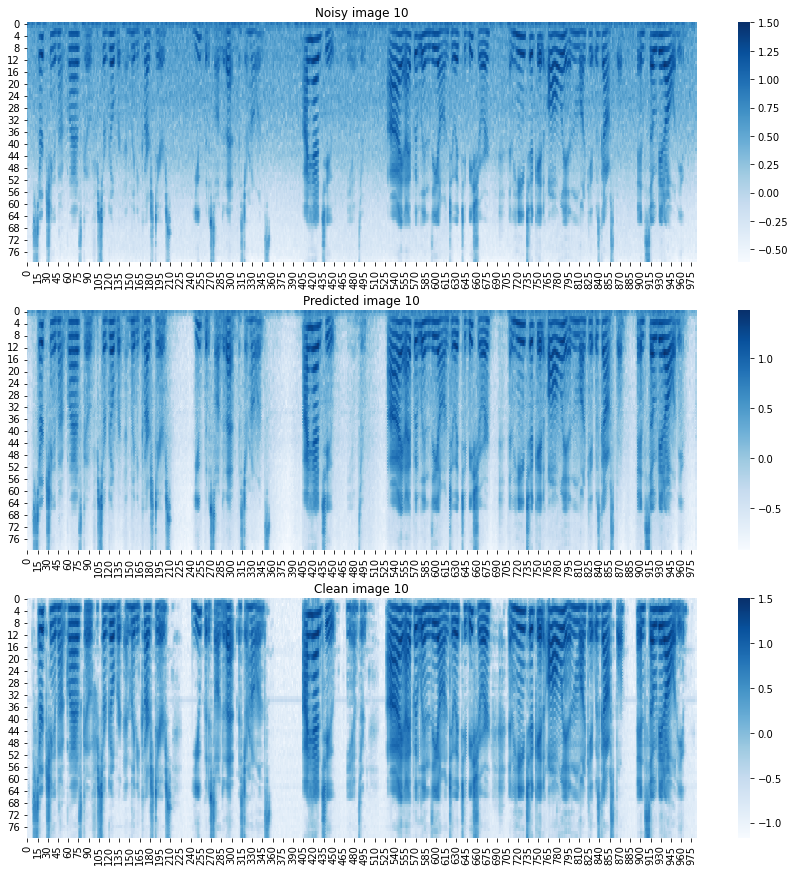

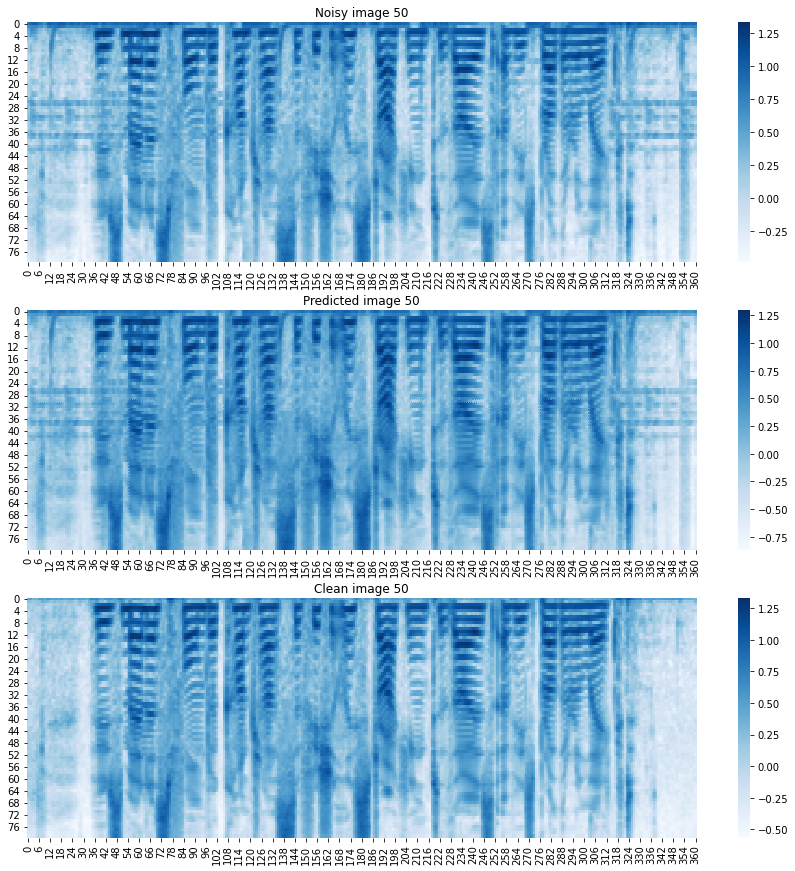

In [102]:
Visualize(loaded_denoising_model, val_clean_data, val_noisy_data, device, [10,50])

---------------------------------------------------

# Test model

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [22]:
device = ''
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
print(f'Your device is "{device}"')

Your device is "cpu"


**здесь необходимо прописать правильный путь до тестовой выборки**

In [3]:
test_path = './val/val/'

In [4]:
def get_clean_data_paths(path: str):
    clean = 'clean/'
    list_clean = []
    with os.scandir(path+clean) as entries:
        for entry in entries:
            if entry.is_dir():
                list_clean.append(entry.path)
    return sorted(list_clean)

In [5]:
def get_data_from_clean_data_paths(clean_data_paths: list):
    """
    input: paths to clean data
    output: loaded clean and noisy data to lists of np.arrays    
    """
    list_of_clean_data = []
    list_of_noisy_data = []

    #scans every dir path
    cnt = 0
    #print(len(clean_data_paths))
    for path in clean_data_paths:
        cnt += 1
        if cnt % 10 == 0:
            print(cnt, path)
        #scans every file in current dir
        with os.scandir(path) as entries:
            for input in entries:
                if input.is_file():
                    clean_path = input.path
                    noisy_path = input.path.replace('clean', 'noisy', 1)

                    list_of_clean_data.append(np.load(clean_path).T)
                    list_of_noisy_data.append(np.load(noisy_path).T)
    return list_of_clean_data, list_of_noisy_data
      

In [6]:
def get_DataLoader(clean_data_list, noisy_data_list, batch_size, shuffle=True):
   
    dataset = Detect(clean_data_list, noisy_data_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                            collate_fn=match_function, pin_memory=True)
    return dataloader

In [13]:
class Detect(Dataset):
    """
      data - clean and noisy data
      targets - noise residuals of the same size as noisy or clean data
    """
    def __init__(self, clean, noisy):
        #initialize class object
        
        #concatenate clean and noisy data lists
        self.data = noisy
        #generate corresponding targets
        self.targets = [noisy[i]-clean[i] for i in range(len(clean))]
        
    def __len__(self):
        #standard interface function for Dataset
        if self.data != None:
            return len(self.data)
        
    def __getitem__(self, idx):
        #standard interface function for Dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.data[idx], self.targets[idx]] #{'mel_data': self.data[idx], 'target': self.targets[idx]}
        return sample

In [14]:
class Denoising_Model(nn.Module):
    """
    Model definition.
    If Y is residual, X is clean data and Y' is noisy data, then CNN output will be 
        Y = Y'- X,
    and accordingly our objective will be computed as 
        X = Y' - Y
    Layers:
        1 Conv1D layer+ReLU,
        18 Conv1D layers+BatchNorm+RelU,
        1 Conv1D layer
    """
    def __init__(self, nLayers=10):
        super(Denoising_Model, self).__init__()
        #DnCNN like architecture
        self.repeated_layers = nLayers-2
        self.conv_list = nn.ModuleList()
        for nLayer in range(self.repeated_layers):
            self.conv_list.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
            self.conv_list.append(nn.BatchNorm1d(64))
            self.conv_list.append(nn.ReLU())
            if nLayer > 0 and nLayer % 4 == 0:
                self.conv_list.append(nn.Dropout(0.5))
        
        self.ConvFirst = nn.Conv1d(in_channels=80, out_channels=64, kernel_size=3, padding=1)
        self.ConvLast = nn.Conv1d(in_channels=64, out_channels=80, kernel_size=3, padding=1)
        
        
    def forward(self, inputs):
        x = F.relu(self.ConvFirst(inputs))
        
        for layer in self.conv_list:
            x = layer(x)
        
        x = self.ConvLast(x)
        
        return x

In [15]:
def Model_evaluate(model, dataloader, device):
  
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    summ_loss = 0.
    processed_sample = 0
    for batch_number, data in enumerate(dataloader):
        samples, targets = data[0], data[1]
        samples, targets = samples.to(device) , targets.to(device)

        model_predictions = model(samples)
        targets = targets
        samples = samples
        mel_predictions = samples - model_predictions
        mel_targets = samples - targets
        
        summ_loss += criterion(mel_predictions, mel_targets).item()
        processed_sample += targets.shape[0]
    
    print(f"\nEval dataset statistics: "
          f"eval_mse_loss = {summ_loss/processed_sample:7.6f}\n")
    
    return summ_loss/processed_sample

In [29]:
def Save_results(model, clean_data, noisy_data, device):
    
    model.eval()
    dataset = Detect(clean_data, noisy_data)
    criterion = nn.MSELoss(reduction='mean')
    os.mkdir("model_predict")
    #cnt = 0
    for data_idx in range(len(dataset)):
        data = dataset[data_idx]
        sample, target = torch.tensor(data[0]).unsqueeze(0).float(), torch.tensor(data[1]).unsqueeze(0).float()
        sample, target = sample.to(device) , target.to(device)

        prediction = model(sample)
        mel_prediction = sample - prediction
        mel_target = sample - target
        
        loss = criterion(mel_prediction, mel_target).item()
        
        mel_prediction = mel_prediction.squeeze(0).cpu().detach().numpy() #<-- необходимо для сохранения
        
        file_name = f'model_predict/prediction_{data_idx}.npy'
        with open(file_name, 'wb') as f:
            np.save(f, mel_prediction)
        #cnt += 1
        pass

In [17]:
def Visualize(model, clean_data, noisy_data, device, list_of_indeces_to_check):
   
    model.eval()
    dataset = Detect(clean_data, noisy_data)
    criterion = nn.MSELoss(reduction='mean')
    #print('len dataset', len(dataset))
    for data_idx in list_of_indeces_to_check:
        data = dataset[data_idx]
        sample, target = torch.tensor(data[0]).unsqueeze(0).float(), torch.tensor(data[1]).unsqueeze(0).float()
        sample, target = sample.to(device) , target.to(device)

        prediction = model(sample)
        mel_prediction = sample - prediction
        mel_target = sample - target
        
        loss = criterion(mel_prediction, mel_target).item()
        
        sample = sample.squeeze(0).cpu().detach().numpy()
        mel_prediction = mel_prediction.squeeze(0).cpu().detach().numpy()
        mel_target = mel_target.squeeze(0).cpu().detach().numpy()
        print(f'spectrogram {data_idx}, loss={loss:5.1}\n')
        
        plt.figure(figsize=(15,15))
        plt.subplot(311)
        plt.title(f'Noisy image {data_idx}')
        sns.heatmap(sample, cmap="Blues")
        plt.subplot(312)
        plt.title(f'Predicted image {data_idx}')
        sns.heatmap(mel_prediction, cmap="Blues")
        plt.subplot(313)
        plt.title(f'Clean image {data_idx}')
        sns.heatmap(mel_target, cmap="Blues")
        pass


In [19]:
def crop_function(arr1, arr2, step):
  
    start_cut_range = arr1.shape[1] - step
    start_rand = np.random.randint(0, start_cut_range+1)

    return (arr1[:, start_rand: start_rand+step], arr2[:, start_rand: start_rand+step])


def match_function(batch):

    min_len = 100000

    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    for elem in data:
        min_len = min(min_len, elem.shape[1])
    
    temp_pairs = [crop_function(elem[0], elem[1], min_len) for elem in zip(data, targets)]
    data = [elem[0] for elem in temp_pairs]
    targets = [elem[1] for elem in temp_pairs]
    return [torch.tensor(data).float(), torch.tensor(targets).float()]

# Load test data

In [23]:
test_clean_paths_list = get_clean_data_paths(test_path)
test_clean_data, test_noisy_data = get_data_from_clean_data_paths(test_clean_paths_list[:])
test_dataloader = get_DataLoader(test_clean_data, test_noisy_data, batch_size=1, shuffle=False)

10 ./val/val/clean/1680
20 ./val/val/clean/2237
30 ./val/val/clean/2925
40 ./val/val/clean/3779
50 ./val/val/clean/428
60 ./val/val/clean/4931
70 ./val/val/clean/5545
80 ./val/val/clean/5970
90 ./val/val/clean/6184
100 ./val/val/clean/6590
110 ./val/val/clean/6963
120 ./val/val/clean/7331
130 ./val/val/clean/7702
140 ./val/val/clean/8259
150 ./val/val/clean/985


# Load train model

In [24]:
loaded_denoising_model = Denoising_Model(15)

model_state_dict = torch.load('./denoiser_best.pth') 
#here you should indicate the best model


#print(model_state_dict)
loaded_denoising_model.load_state_dict(model_state_dict)
loaded_denoising_model.to(device);

In [25]:
test_loss = Model_evaluate(loaded_denoising_model, test_dataloader, device)
print(f'MSE = {test_loss:6.4}')


Eval dataset statistics: eval_mse_loss = 0.041412

MSE = 0.04141


# Save results

In [26]:
Save_results(loaded_denoising_model, test_clean_data, test_noisy_data, device)

# Open to confirm results

In [27]:
np.load('./model_predict/prediction_0.npy')

array([[-0.08566818, -0.21422786, -0.04407603, ..., -0.24410409,
        -0.16028687,  0.14774346],
       [-0.15403086, -0.22861916, -0.19214264, ..., -0.29367632,
        -0.14318869,  0.11623967],
       [-0.18586102, -0.24076873, -0.2104283 , ..., -0.2538492 ,
        -0.16559318,  0.11903408],
       ...,
       [-0.6006224 , -0.6864625 , -0.7147259 , ..., -0.59158224,
        -0.46095604, -0.27837902],
       [-0.64058614, -0.7460583 , -0.70550346, ..., -0.62670004,
        -0.45030192, -0.2859894 ],
       [-0.5364187 , -0.6772692 , -0.7394664 , ..., -0.5578798 ,
        -0.33096775, -0.2221758 ]], dtype=float32)

# Visualisation

spectrogram 0, loss=  0.1



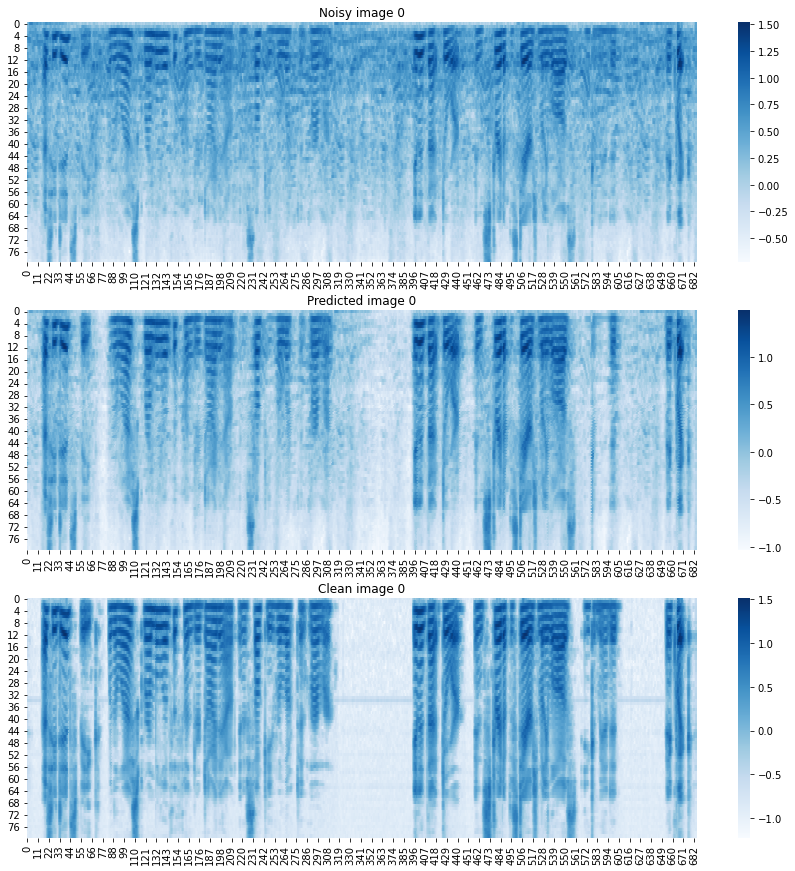

In [20]:
Visualize(loaded_denoising_model, test_clean_data, test_noisy_data, device, [0])

spectrogram 40, loss= 0.02



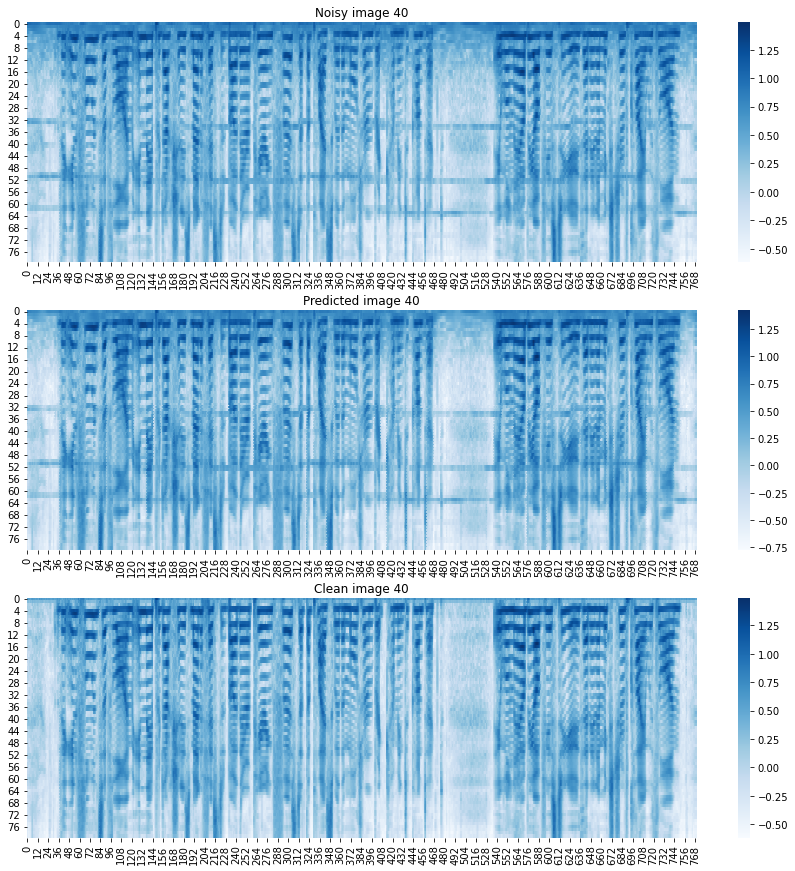

In [91]:
Visualize(loaded_denoising_model, test_clean_data, test_noisy_data, device, [40])